# Processed Data Analysis

This notebook is dedicated to exploring the processed data through comprehensive analysis and visualization.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.eye_tracking_data import (
    get_gaze_data,
    with_media_type_column,
    with_time_since_start_column,
    with_time_since_last_column,
    with_distance_since_last_column,
    with_speed_since_last_column,
)

N_NANOSECONDS_IN_SECOND = 1e9  # Number of nanoseconds in a second
OUTPUT_FILE_PATH = "../data/result.mp4"

## Loading Processed Data

In [3]:
data = get_gaze_data()
data = with_media_type_column(data)
data = with_time_since_start_column(data)
data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,SetId,X_sc,Y_sc,X_px,Y_px,Timestamp_ns,MediaType,TimeSinceStart_ns
0,1,1,1,1,1,0.813762,0.661315,4999.7515,2031.5590,8492802345543344252,Image,0
1,1,1,1,1,1,0.739250,0.870603,4541.9500,2674.4930,8492802345801721952,Image,258377700
2,1,1,1,1,1,0.680598,0.649704,4181.5950,1995.8899,8492802345847617152,Image,304272900
3,1,1,1,1,1,0.663174,0.657053,4074.5400,2018.4670,8492802345951811152,Image,408466900
4,1,1,1,1,1,0.548628,0.777003,3370.7708,2386.9520,8492802346058247252,Image,514903000


In [4]:
interpolated_data = get_gaze_data(interpolated=True)
interpolated_data = with_media_type_column(interpolated_data)
interpolated_data = with_time_since_start_column(interpolated_data)
interpolated_data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,SetId,X_sc,Y_sc,X_px,Y_px,Timestamp_ns,MediaType,TimeSinceStart_ns
0,1,1,1,1,1,0.813762,0.661315,4999.7515,2031.5590,8492802345500000000,Image,0
1,1,1,1,1,1,0.796455,0.677788,4893.4220,2082.1643,8492802345550000000,Image,50000000
2,1,1,1,1,1,0.779149,0.694261,4787.0920,2132.7698,8492802345600000000,Image,100000000
3,1,1,1,1,1,0.761843,0.710734,4680.7617,2183.3752,8492802345650000000,Image,150000000
4,1,1,1,1,1,0.744536,0.727207,4574.4320,2233.9805,8492802345700000000,Image,200000000


In [5]:
fixation_data = get_gaze_data(fixation=True)
fixation_data = with_media_type_column(fixation_data)
fixation_data = with_time_since_start_column(fixation_data)
fixation_data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,SetId,X_sc,Y_sc,X_px,Y_px,StartTimestamp_ns,EndTimestamp_ns,Duration_ns,MediaType,TimeSinceStart_ns
0,1,1,1,1,1,0.456977,0.742343,2807.6680,2280.4790,8492802347900000000,8492802348150000000,250000000,Image,0
1,1,1,1,1,1,0.558270,0.973386,3430.0080,2990.2402,8492802348150000000,8492802348450000000,300000000,Image,250000000
2,1,1,1,1,1,0.862491,0.557093,5299.1445,1711.3899,8492802349250000000,8492802349500000000,250000000,Image,1350000000
3,1,1,1,1,1,0.883241,0.562619,5426.6310,1728.3650,8492802349500000000,8492802349750000000,250000000,Image,1600000000
4,1,1,1,1,1,0.772883,0.622203,4748.5930,1911.4080,8492802350350000000,8492802350600000000,250000000,Image,2450000000


## Number of Data Points Over Time

In [12]:
def plot_number_data_points_over_time(
    data: pd.DataFrame,
) -> None:
    """
    Plot data point frequency over time.

    Args:
        data (pandas.DataFrame): The data to plot.
    """
    # Convert the time to seconds
    data = data.copy()
    data["TimeSinceStart_s"] = (
        data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND
    ).astype(int)
    data["Legend"] = data.apply(
        lambda row: f"Experiment {int(row['ExperimentId'])} Session {int(row['SessionId'])}",
        axis=1,
    )
    data = data.groupby(["Legend", "TimeSinceStart_s"]).size().reset_index(name="count")

    # Update data to fit the plot
    pivot_data = data.pivot(
        index="TimeSinceStart_s", columns="Legend", values="count"
    ).fillna(0)

    # Plot the histogram
    pivot_data.plot(kind="bar", stacked=True, figsize=(7, 4), width=1)
    plt.xlabel("Time (s)")
    plt.xticks(range(0, pivot_data.index.max(), 15))
    plt.ylabel("Number of data points")
    plt.title("Number of data points over time")
    plt.legend()
    plt.tight_layout()
    plt.show()

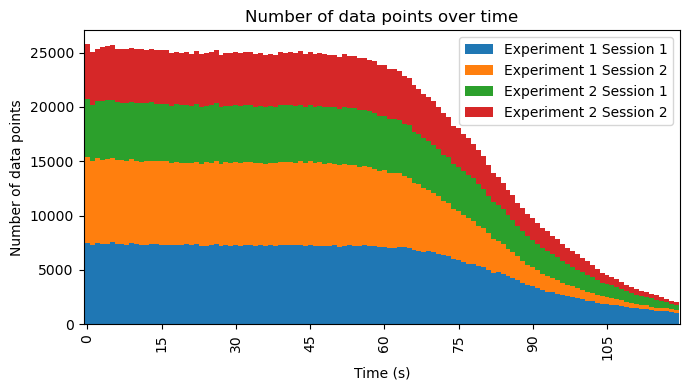

In [13]:
plot_number_data_points_over_time(data)

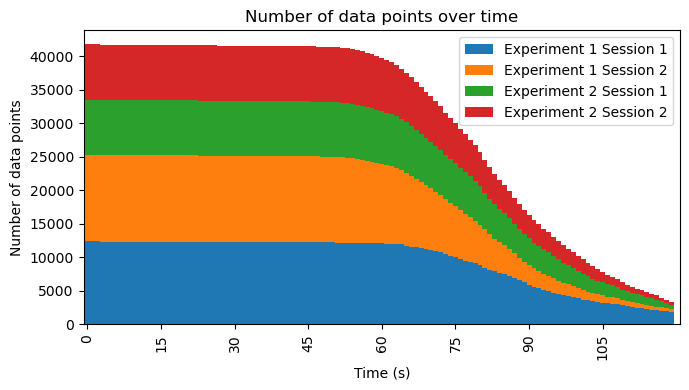

In [14]:
plot_number_data_points_over_time(interpolated_data)

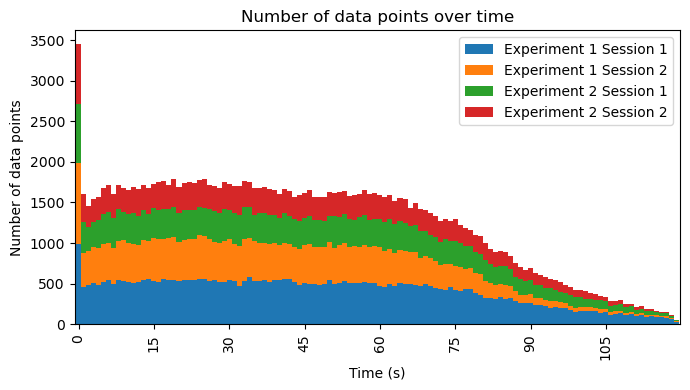

In [15]:
plot_number_data_points_over_time(fixation_data)

## Proportion of Fixations Over Time

In [16]:
def plot_fixation_proportion_over_time(
    data: pd.DataFrame, fixation_data: pd.DataFrame
) -> None:
    """
    Plot fixation proportion over time.

    Args:
        data (pandas.DataFrame): The data to plot.
        fixation_data (pandas.DataFrame): The fixation data to plot.
    """
    data = data.copy()
    fixation_data = fixation_data.copy()
    data["TimeSinceStart_s"] = (
        data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND
    ).astype(int)
    fixation_data["TimeSinceStart_s"] = (
        fixation_data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND
    ).astype(int)
    data = data.groupby(["TimeSinceStart_s"]).size().reset_index(name="count")
    fixation_data = (
        fixation_data.groupby(["TimeSinceStart_s"]).size().reset_index(name="count")
    )

    data = data.set_index("TimeSinceStart_s")
    fixation_data = fixation_data.set_index("TimeSinceStart_s")

    data["FixationCount"] = fixation_data["count"]
    data["FixationProportion"] = data["FixationCount"] / data["count"]

    plt.figure(figsize=(7, 4))
    sns.lineplot(data=data["FixationProportion"])
    plt.xlabel("Time (s)")
    plt.ylabel("Fixation proportion")
    plt.title("Fixation proportion over time")
    plt.tight_layout()
    plt.show()

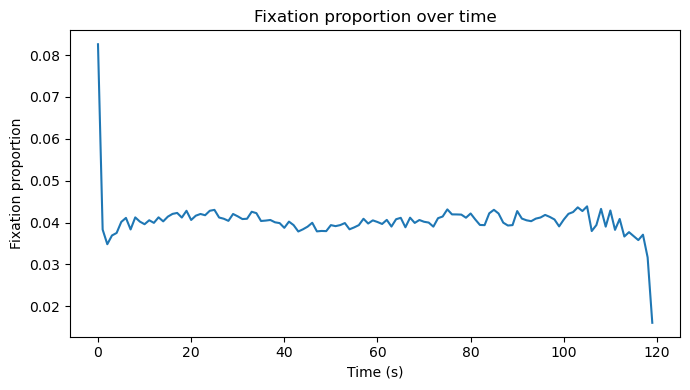

In [17]:
plot_fixation_proportion_over_time(interpolated_data, fixation_data)

## Gaze Time Distribution

In [85]:
def plot_gaze_time(data: pd.DataFrame, remove_outliers: bool = True) -> None:
    """
    Plot time since last gaze point distribution.

    Args:
        data (pd.DataFrame): The data to plot.
        remove_outliers (bool, optional): Whether to remove outliers. Defaults to True.
    """
    # Add the time since last gaze point column
    data = data.copy()
    data = with_time_since_last_column(data)
    data["Experiment_Session"] = data.apply(
        lambda row: f"Exp {int(row['ExperimentId'])} Ses {int(row['SessionId'])}",
        axis=1,
    )

    # Remove outliers based on quantiles
    data = data.copy()
    if remove_outliers:
        q_low = data["TimeSinceLast_ns"].quantile(0.05)
        q_hi = data["TimeSinceLast_ns"].quantile(0.95)
        data = data[
            (data["TimeSinceLast_ns"] < q_hi) & (data["TimeSinceLast_ns"] > q_low)
        ]

    # Plot histogram
    plt.figure(figsize=(7, 5))
    sns.histplot(
        data=data,
        x="TimeSinceLast_ns",
        hue="Experiment_Session",
        bins=50,
        log_scale=True,
    )
    plt.xlabel("Time since last gaze point (ns)")
    plt.ylabel("Number of data points")
    plt.title(
        f"Time since last gaze point distribution {'(outliers removed)' if remove_outliers else ''}"
    )
    plt.tight_layout()
    plt.show()

    # Print median and mean
    print(f"Median: {data.groupby('Experiment_Session')['TimeSinceLast_ns'].median()}")
    print(f"Mean: {data.groupby('Experiment_Session')['TimeSinceLast_ns'].mean()}")

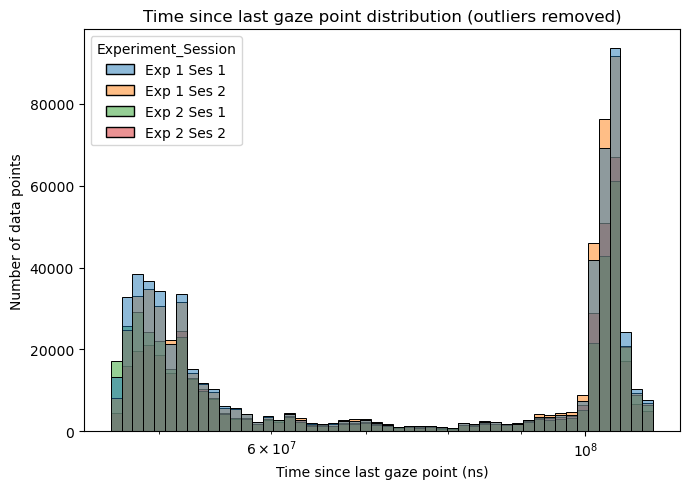

Median: Experiment_Session
Exp 1 Ses 1    71020700.0
Exp 1 Ses 2    86709600.0
Exp 2 Ses 1    62577900.0
Exp 2 Ses 2    88778200.0
Name: TimeSinceLast_ns, dtype: float64
Mean: Experiment_Session
Exp 1 Ses 1    7.679389e+07
Exp 1 Ses 2    7.839726e+07
Exp 2 Ses 1    7.529048e+07
Exp 2 Ses 2    7.892665e+07
Name: TimeSinceLast_ns, dtype: float64


In [86]:
plot_gaze_time(data, remove_outliers=True)

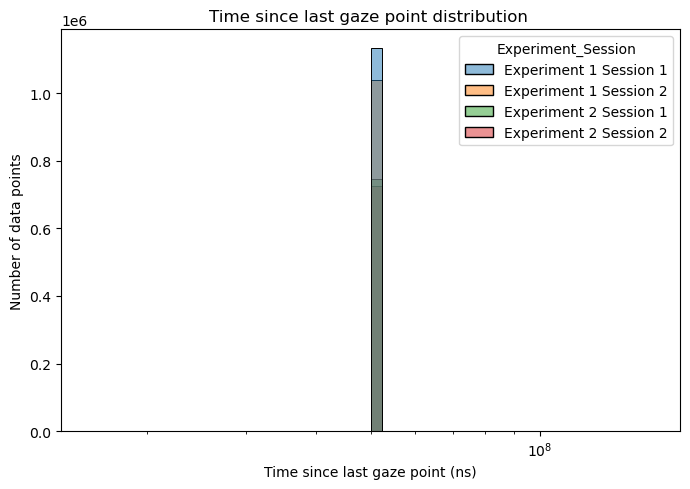

Median: Experiment_Session
Experiment 1 Session 1    50000000.0
Experiment 1 Session 2    50000000.0
Experiment 2 Session 1    50000000.0
Experiment 2 Session 2    50000000.0
Name: TimeSinceLast_ns, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    4.997273e+07
Experiment 1 Session 2    4.996896e+07
Experiment 2 Session 1    4.997239e+07
Experiment 2 Session 2    4.997144e+07
Name: TimeSinceLast_ns, dtype: float64


In [33]:
plot_gaze_time(interpolated_data, remove_outliers=False)

## Gaze Distance Distribution

In [30]:
def plot_gaze_distance(data: pd.DataFrame, remove_outliers: bool = True) -> None:
    """
    Plot distance since last gaze point distribution.

    Args:
        data (pd.DataFrame): The data to plot.
        remove_outliers (bool, optional): Whether to remove outliers. Defaults to True.
    """
    # Add the distance since last gaze point column
    data = data.copy()
    data = with_distance_since_last_column(data)
    data["Experiment_Session"] = data.apply(
        lambda row: f"Experiment {int(row['ExperimentId'])} Session {int(row['SessionId'])}",
        axis=1,
    )

    # Remove outliers based on quantiles
    data = data.copy()
    if remove_outliers:
        q_low = data["DistanceSinceLast_px"].quantile(0.025)
        q_hi = data["DistanceSinceLast_px"].quantile(0.95)
        data = data[
            (data["DistanceSinceLast_px"] < q_hi)
            & (data["DistanceSinceLast_px"] > q_low)
        ]

    # Plot histogram
    plt.figure(figsize=(7, 5))
    sns.histplot(
        data=data,
        x="DistanceSinceLast_px",
        hue="Experiment_Session",
        bins=50,
        log_scale=True,
    )
    plt.xlabel("Distance since last gaze point (px)")
    plt.ylabel("Number of data points")
    plt.title(
        f"Distance since last gaze point distribution {'(outliers removed)' if remove_outliers else ''}"
    )
    plt.tight_layout()
    plt.show()

    # Print median and mean
    print(
        f"Median: {data.groupby('Experiment_Session')['DistanceSinceLast_px'].median()}"
    )
    print(f"Mean: {data.groupby('Experiment_Session')['DistanceSinceLast_px'].mean()}")

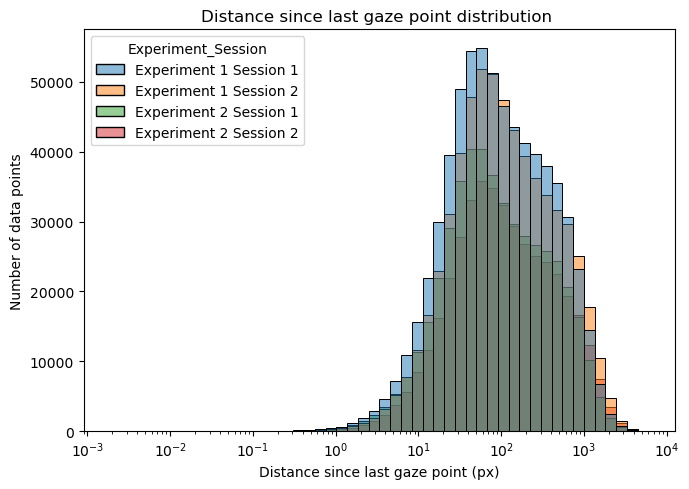

Median: Experiment_Session
Experiment 1 Session 1    84.714296
Experiment 1 Session 2    98.843907
Experiment 2 Session 1    79.275803
Experiment 2 Session 2    97.611886
Name: DistanceSinceLast_px, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    219.305041
Experiment 1 Session 2    259.519388
Experiment 2 Session 1    215.316910
Experiment 2 Session 2    259.584030
Name: DistanceSinceLast_px, dtype: float64


In [34]:
plot_gaze_distance(data, remove_outliers=False)

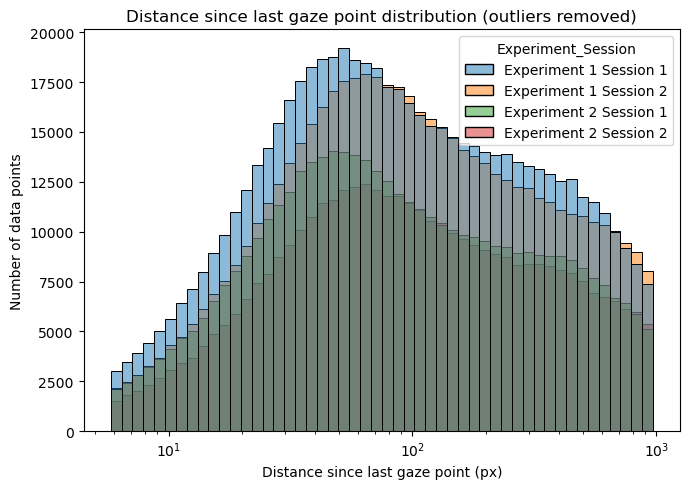

Median: Experiment_Session
Experiment 1 Session 1    82.684254
Experiment 1 Session 2    91.794110
Experiment 2 Session 1    77.701993
Experiment 2 Session 2    90.505224
Name: DistanceSinceLast_px, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    176.263119
Experiment 1 Session 2    186.072759
Experiment 2 Session 1    171.410500
Experiment 2 Session 2    183.622015
Name: DistanceSinceLast_px, dtype: float64


In [35]:
plot_gaze_distance(data, remove_outliers=True)

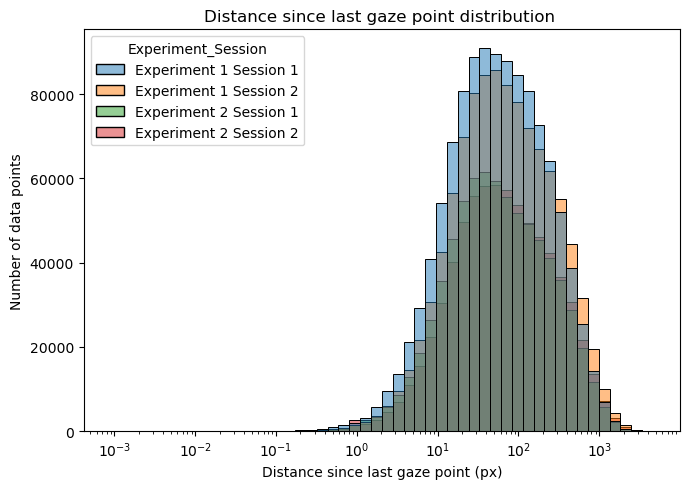

Median: Experiment_Session
Experiment 1 Session 1    53.822081
Experiment 1 Session 2    62.804081
Experiment 2 Session 1    53.272159
Experiment 2 Session 2    61.112772
Name: DistanceSinceLast_px, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    127.209777
Experiment 1 Session 2    153.386224
Experiment 2 Session 1    136.183948
Experiment 2 Session 2    152.258982
Name: DistanceSinceLast_px, dtype: float64


In [36]:
plot_gaze_distance(interpolated_data, remove_outliers=False)

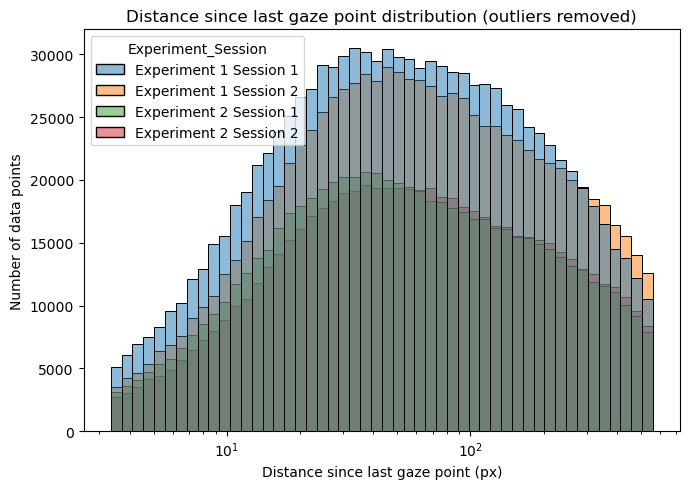

Median: Experiment_Session
Experiment 1 Session 1    52.754830
Experiment 1 Session 2    58.413367
Experiment 2 Session 1    51.223096
Experiment 2 Session 2    57.201622
Name: DistanceSinceLast_px, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    100.952790
Experiment 1 Session 2    110.391164
Experiment 2 Session 1    102.865544
Experiment 2 Session 2    108.728995
Name: DistanceSinceLast_px, dtype: float64


In [37]:
plot_gaze_distance(interpolated_data, remove_outliers=True)

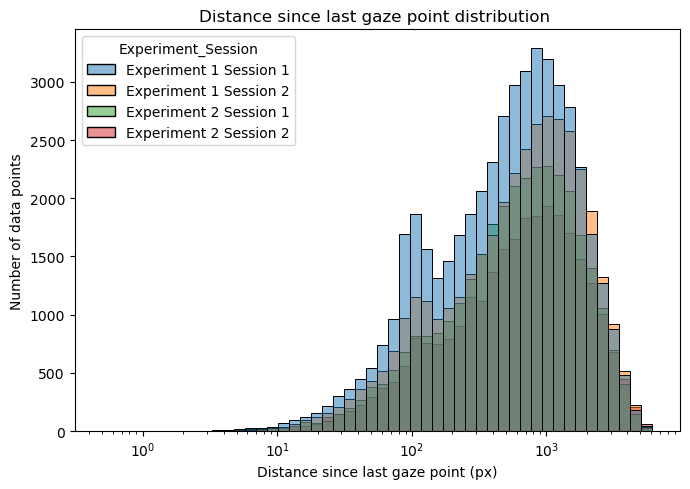

Median: Experiment_Session
Experiment 1 Session 1    562.842027
Experiment 1 Session 2    677.523607
Experiment 2 Session 1    637.393733
Experiment 2 Session 2    656.058184
Name: DistanceSinceLast_px, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    819.500942
Experiment 1 Session 2    937.027309
Experiment 2 Session 1    901.015221
Experiment 2 Session 2    947.824879
Name: DistanceSinceLast_px, dtype: float64


In [38]:
plot_gaze_distance(fixation_data, remove_outliers=False)

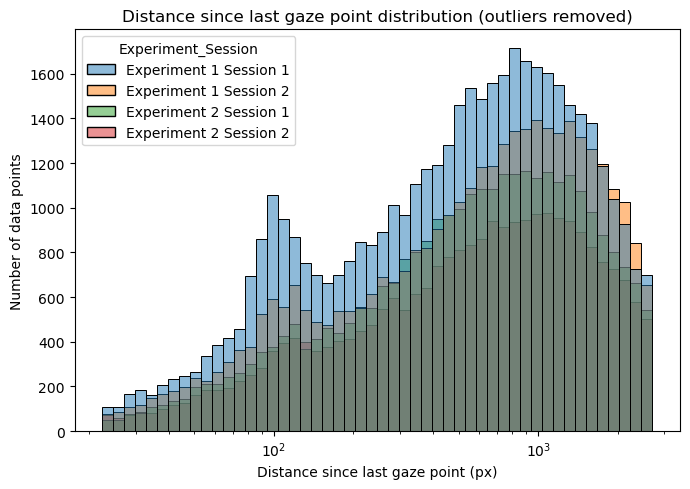

Median: Experiment_Session
Experiment 1 Session 1    550.760256
Experiment 1 Session 2    648.696386
Experiment 2 Session 1    611.807713
Experiment 2 Session 2    619.272362
Name: DistanceSinceLast_px, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    728.499317
Experiment 1 Session 2    817.711741
Experiment 2 Session 1    790.737533
Experiment 2 Session 2    800.117940
Name: DistanceSinceLast_px, dtype: float64


In [39]:
plot_gaze_distance(fixation_data, remove_outliers=True)

## Gaze Speed Distribution

In [44]:
def plot_gaze_speed(
    data: pd.DataFrame,
    bins: int = 50,
) -> None:
    """
    Plot speed since last gaze point distribution.

    Args:
        data (pd.DataFrame): The data to plot.
        bins (int, optional): The number of bins. Defaults to 50.
    """
    # Add the speed since last gaze point column
    data = data.copy()
    data = with_speed_since_last_column(data)
    data["Legend"] = data.apply(
        lambda row: f"Experiment {int(row['ExperimentId'])} Session {int(row['SessionId'])}",
        axis=1,
    )

    # Plot histogram
    plt.figure(figsize=(7, 5))
    sns.histplot(
        data=data,
        x="SpeedSinceLast_pxs",
        hue="Legend",
        bins=bins,
        log_scale=True,
    )
    plt.xlabel("Speed since last gaze point (px)")
    plt.ylabel("Number of data points")
    plt.title(f"Speed since last gaze point distribution")
    plt.tight_layout()
    plt.show()

    # Plot box plot
    plt.figure(figsize=(7, 5))
    sns.boxplot(
        data=data,
        x="ExperimentId",
        y="SpeedSinceLast_pxs",
        hue="SessionId",
        showfliers=False,
    )
    plt.xlabel("Experiment")
    plt.ylabel("Speed since last gaze point (px/s)")
    plt.title(f"Box plot of mean speeds since last gaze point over sequences")
    plt.tight_layout()
    plt.show()

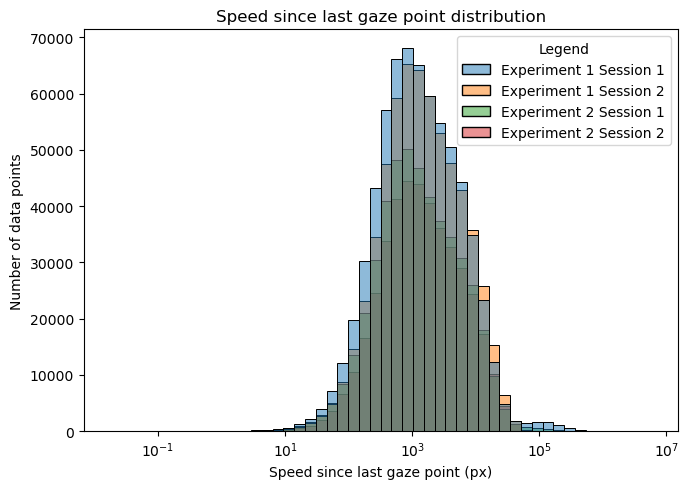

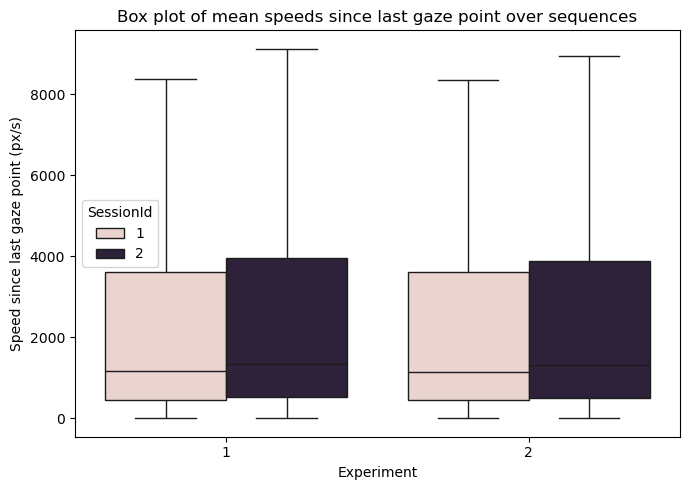

In [45]:
plot_gaze_speed(data)

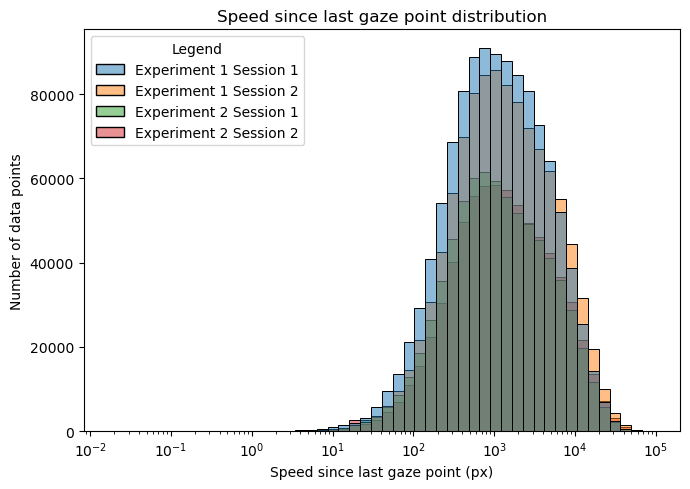

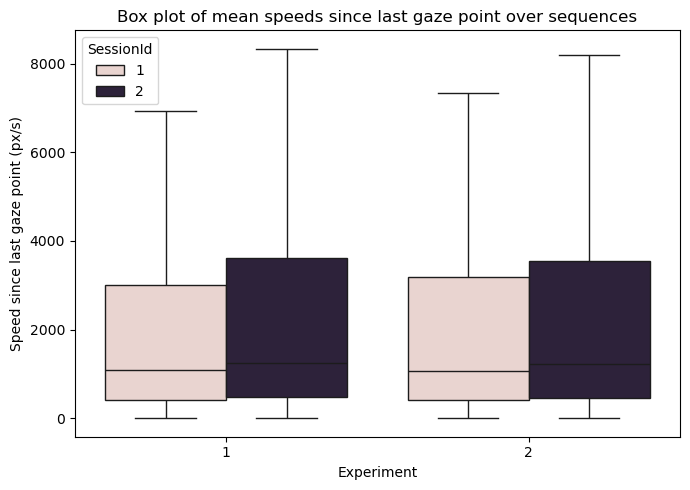

In [46]:
plot_gaze_speed(interpolated_data)

## Gaze and Fixation Distance and Time Over Time

In [59]:
def plot_gaze_distance_time_over_time(
    data: pd.DataFrame,
    remove_outliers: bool = True,
) -> None:
    """
    Plot distance and time since last gaze point over time.

    Args:
        data (pd.DataFrame): The data to plot.
        remove_outliers (bool, optional): Whether to remove outliers. Defaults to True.
    """
    # Add the time and distance since last gaze point column
    data = data.copy()
    data = with_time_since_last_column(data)
    data = with_distance_since_last_column(data)
    data["TimeSinceStart_s"] = (
        data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND
    ).astype(int)
    data["Legend"] = data.apply(
        lambda row: f"Exp {int(row['ExperimentId'])} Ses {int(row['SessionId'])}",
        axis=1,
    )

    # Remove outliers based on quantiles
    if remove_outliers:
        q_low = data["TimeSinceLast_ns"].quantile(0.05)
        q_hi = data["TimeSinceLast_ns"].quantile(0.95)
        data = data[
            (data["TimeSinceLast_ns"] < q_hi) & (data["TimeSinceLast_ns"] > q_low)
        ]
        q_low = data["DistanceSinceLast_px"].quantile(0.05)
        q_hi = data["DistanceSinceLast_px"].quantile(0.95)
        data = data[
            (data["DistanceSinceLast_px"] < q_hi)
            & (data["DistanceSinceLast_px"] > q_low)
        ]

    # Plot the time and distance since last gaze point over time for all sessions
    plt.figure(figsize=(7, 6))
    plt.subplot(2, 1, 1)
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="TimeSinceLast_ns",
        errorbar=('ci', 95),
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Time since last gaze point (ns)")
    plt.title(f"Mean time since last gaze point of all sections over time")
    plt.subplot(2, 1, 2)
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="DistanceSinceLast_px",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Distance since last gaze point (px)")
    plt.title(f"Mean distance since last gaze point of all sections over time")
    plt.suptitle(f"Mean time and distance since last gaze point of all sections over time (95% CI)")
    plt.tight_layout()
    plt.show()

    # Plot the time and distance since last gaze point over time for each session
    plt.figure(figsize=(9, 6))
    plt.subplot(2, 1, 1)
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="TimeSinceLast_ns",
        errorbar=('ci', 95),
        hue="Legend",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Time since last gaze point (ns)")
    plt.title(f"Mean time since last gaze point of each session over time (95% CI)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.subplot(2, 1, 2)
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="DistanceSinceLast_px",
        hue="Legend",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Distance since last gaze point (px)")
    plt.title(f"Mean distance since last gaze point of each session over time")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.suptitle(f"Mean time and distance since last gaze point of each session over time (95% CI)")
    plt.tight_layout()
    plt.show()

    # Plot the time and distance since last gaze point over time for each media type
    plt.figure(figsize=(9, 6))
    plt.subplot(2, 1, 1)
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="TimeSinceLast_ns",
        errorbar=('ci', 95),
        hue="MediaType",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Time since last gaze point (ns)")
    plt.title(f"Mean time since last gaze point of each media type over time (95% CI)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.subplot(2, 1, 2)
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="DistanceSinceLast_px",
        hue="MediaType",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Distance since last gaze point (px)")
    plt.title(f"Mean distance since last gaze point of each media type over time")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.suptitle(f"Mean time and distance since last gaze point of each media type over time (95% CI)")
    plt.tight_layout()
    plt.show()

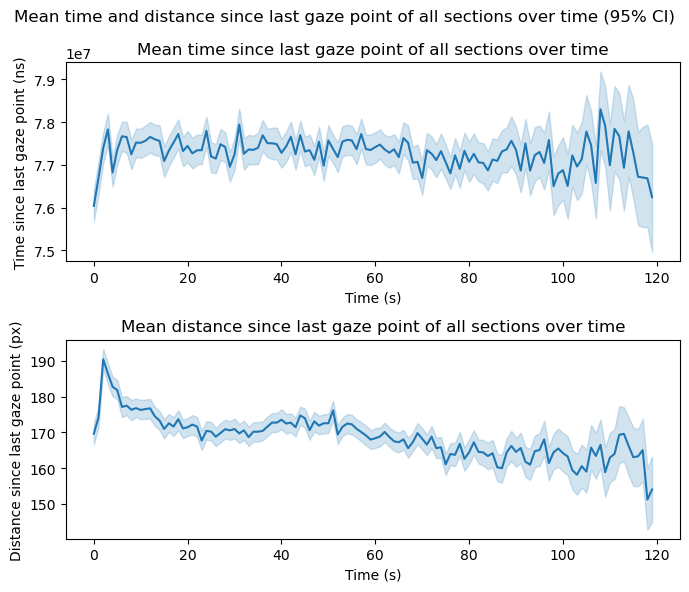

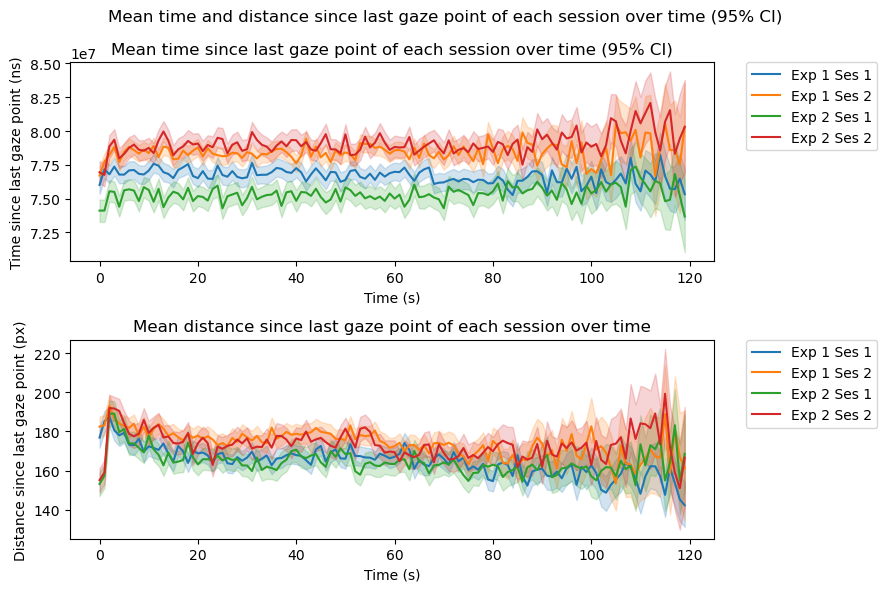

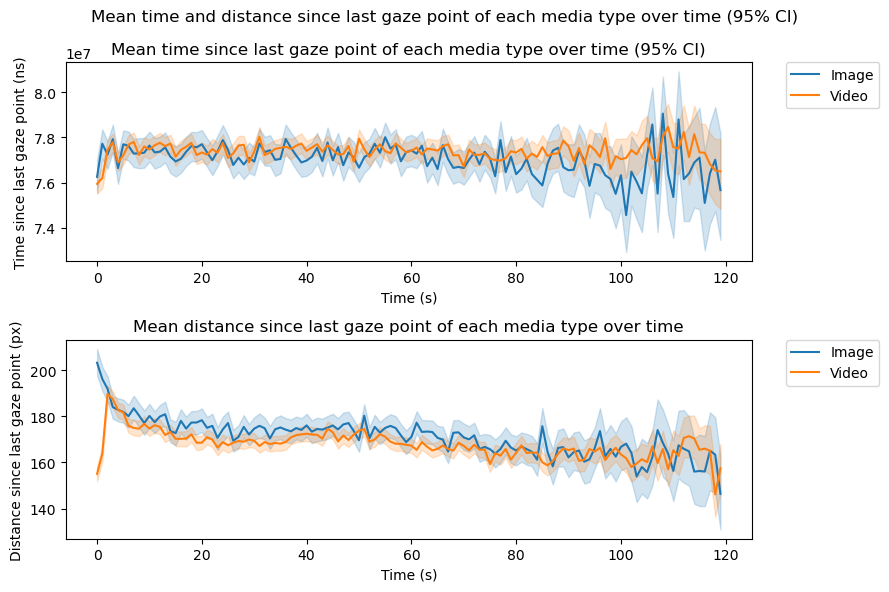

In [60]:
plot_gaze_distance_time_over_time(data, remove_outliers=True)

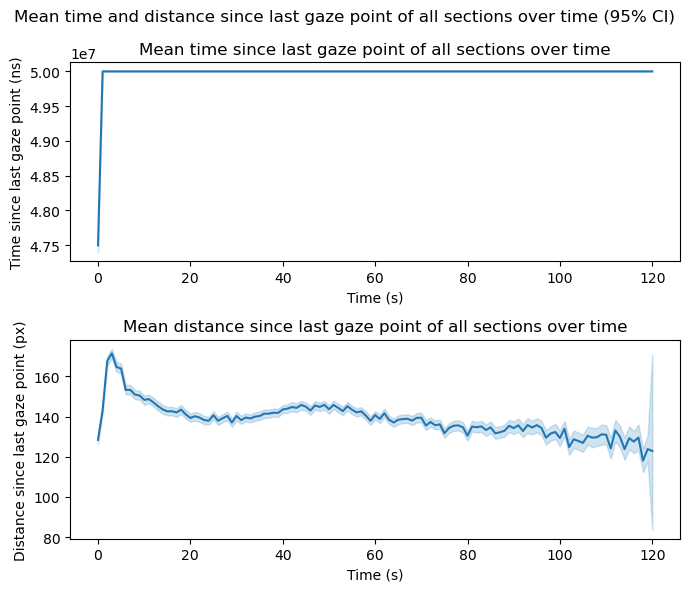

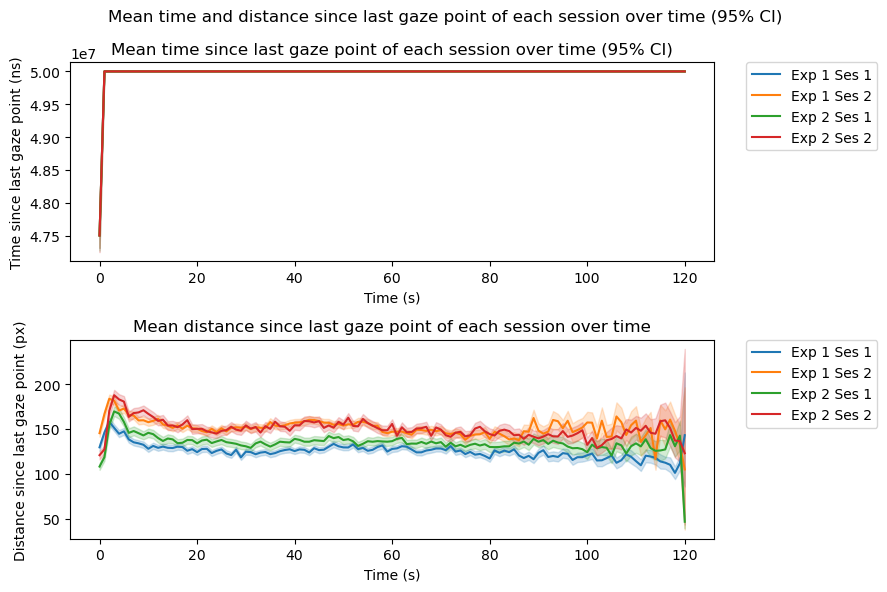

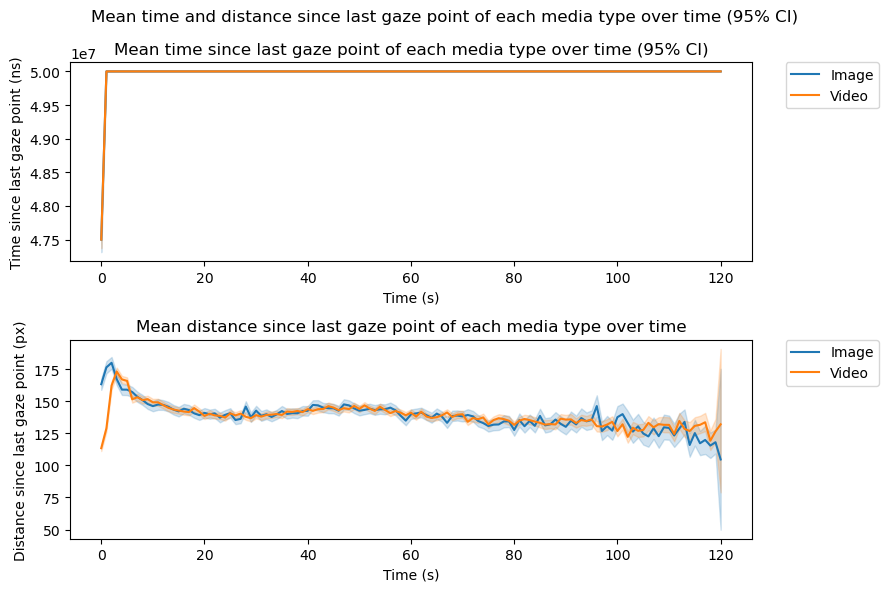

In [61]:
plot_gaze_distance_time_over_time(interpolated_data, remove_outliers=False)

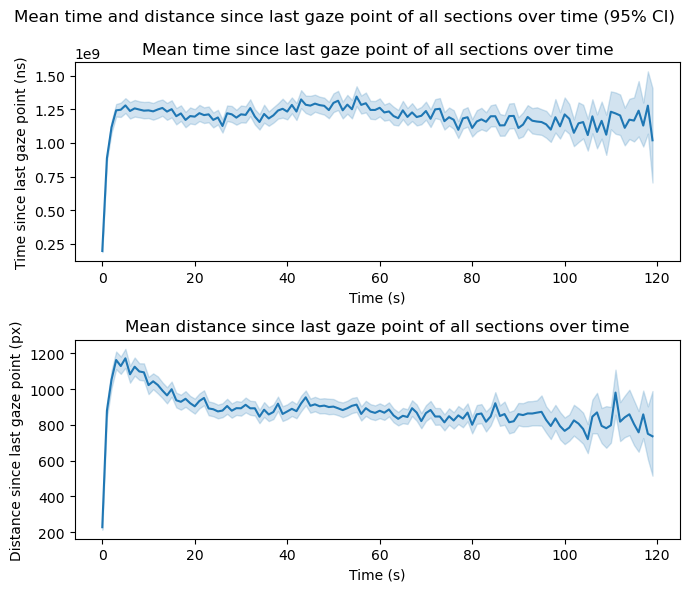

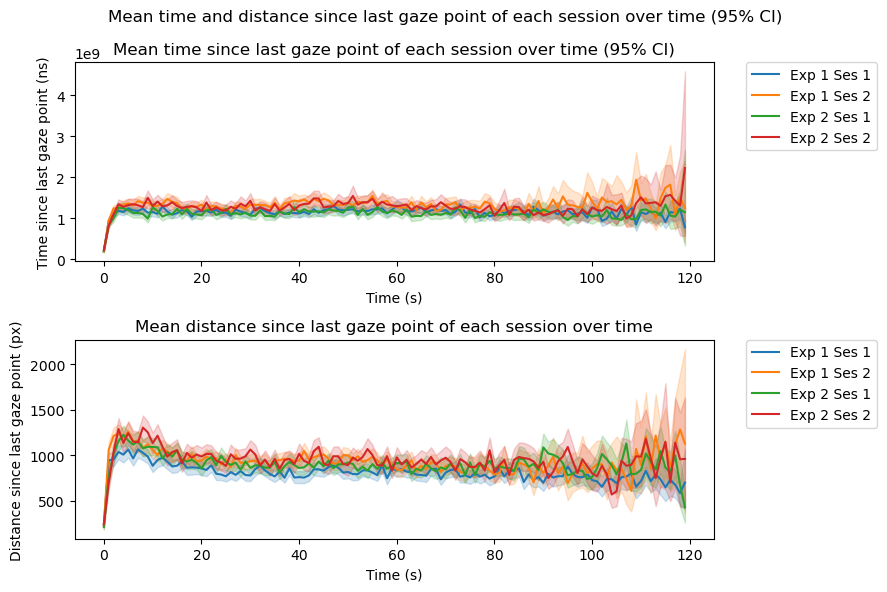

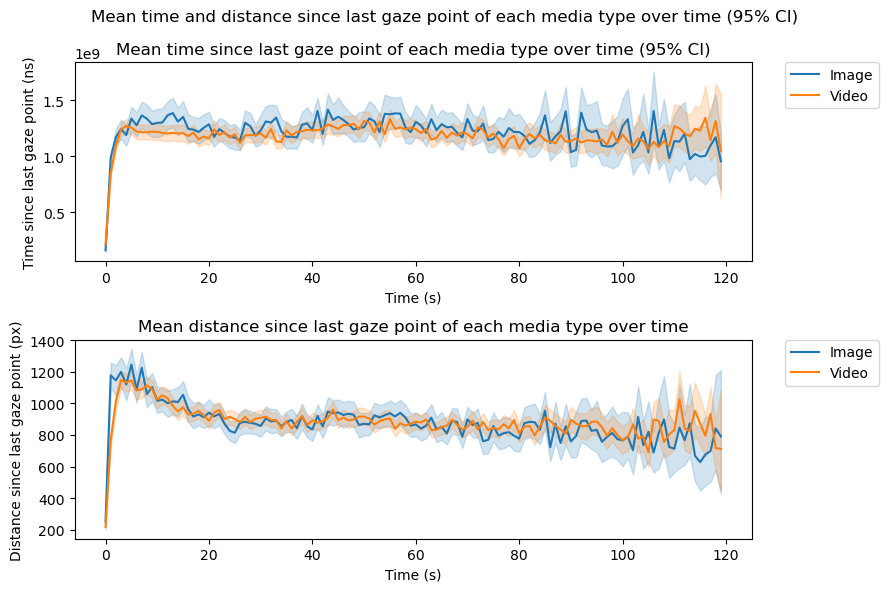

In [62]:
plot_gaze_distance_time_over_time(fixation_data, remove_outliers=False)

## Gaze and Fixation Speed Over Time

In [67]:
def plot_gaze_speed_over_time(
    data: pd.DataFrame,
) -> None:
    """
    Plot speed since the last gaze point over time.

    Args:
        data (pd.DataFrame): The data to plot.
    """
    # Add the speed since last gaze point column
    data = data.copy()
    data = with_speed_since_last_column(data)
    data["TimeSinceStart_s"] = (
        data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND
    ).astype(int)
    data["Legend"] = data.apply(
        lambda row: f"Exp {int(row['ExperimentId'])} Ses {int(row['SessionId'])}",
        axis=1,
    )

    # Plot the speed since last gaze point over time for all sessions
    plt.figure(figsize=(7, 3))
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="SpeedSinceLast_pxs",
        errorbar=('ci', 95),
        label="Mean speed since last gaze point of all sessions",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Speed since last gaze point (px/s)")
    plt.legend()
    plt.title(f"Mean speed since last gaze point of all sections over time (95% CI)")
    plt.tight_layout()
    plt.show()

    # Plot the speed since last gaze point over time for each session
    plt.figure(figsize=(9, 3))
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="SpeedSinceLast_pxs",
        errorbar=('ci', 95),
        hue="Legend",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Speed since last gaze point (px/s)")
    plt.title(f"Mean speed since last gaze point of each session over time (95% CI)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    # Plot the speed since last gaze point over time for each media type
    plt.figure(figsize=(9, 3))
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="SpeedSinceLast_pxs",
        errorbar=('ci', 95),
        hue="MediaType",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Speed since last gaze point (px/s)")
    plt.title(f"Mean speed since last gaze point of each media type over time (95% CI)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

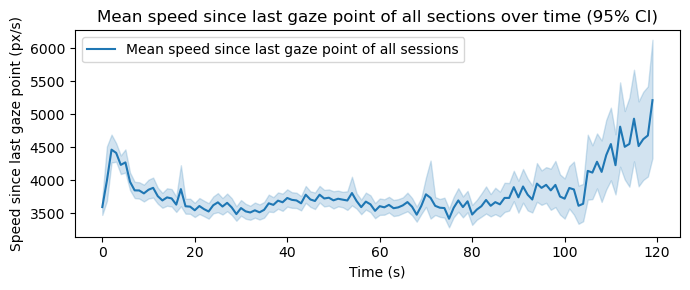

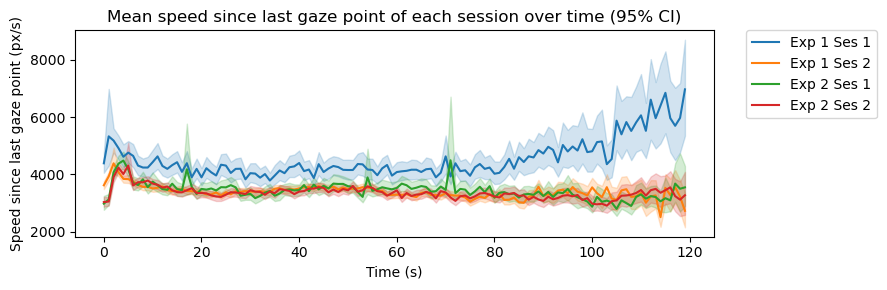

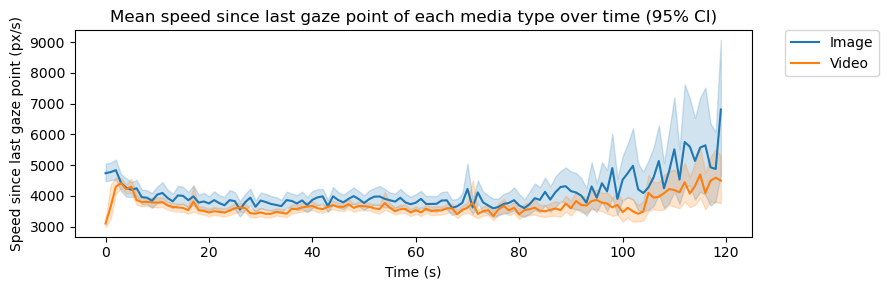

In [68]:
plot_gaze_speed_over_time(data)

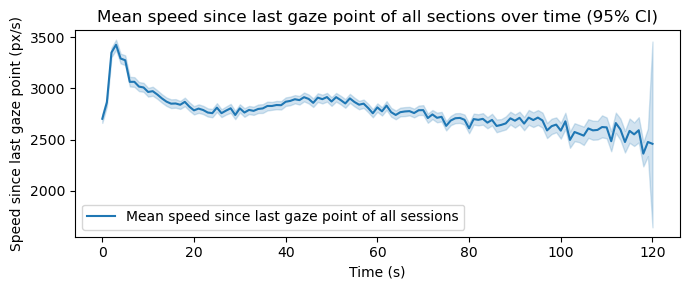

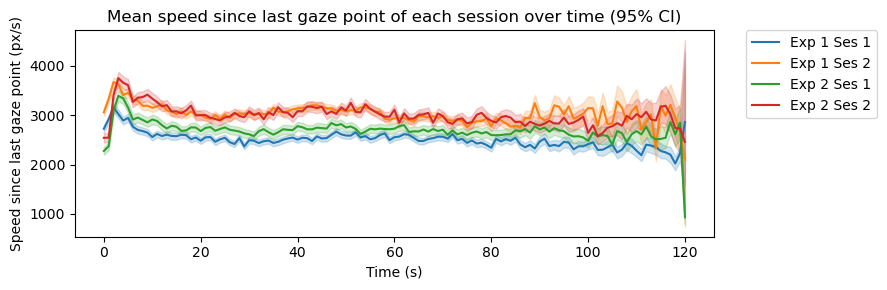

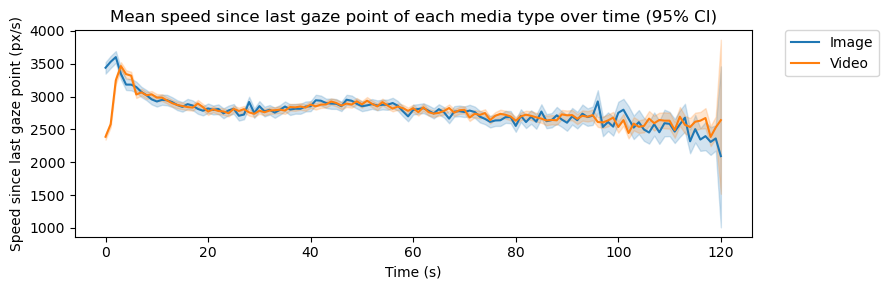

In [69]:
plot_gaze_speed_over_time(interpolated_data)

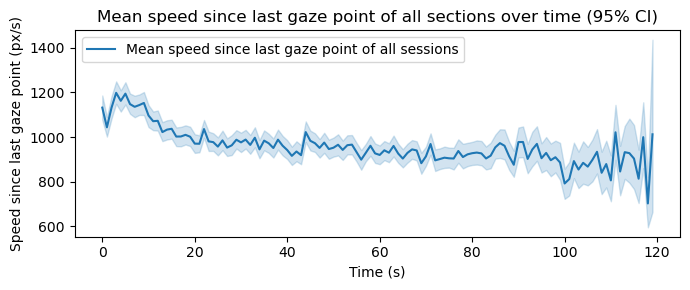

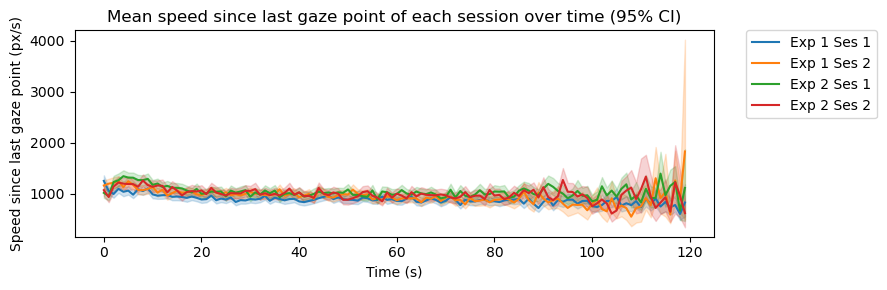

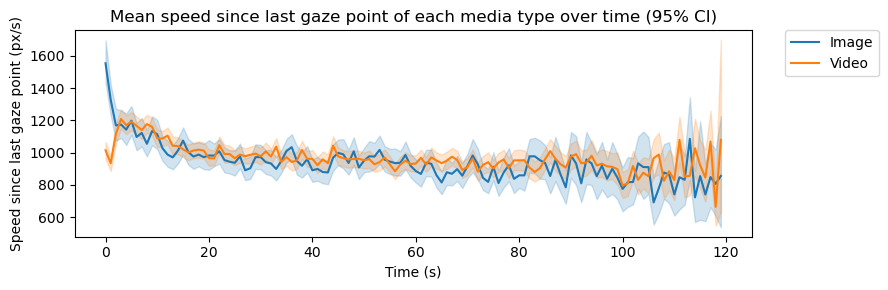

In [70]:
plot_gaze_speed_over_time(fixation_data)

## Fixation Duration Over Time

In [78]:
def plot_fixation_duration_over_time(
        data: pd.DataFrame,
) -> None:
    """
    Plot fixation duration over time.

    Args:
        data (pd.DataFrame): The data to plot.
    """
    data = data.copy()
    data["TimeSinceStart_s"] = (
        data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND
    ).astype(int)
    data["Legend"] = data.apply(
        lambda row: f"Exp {int(row['ExperimentId'])} Ses {int(row['SessionId'])}",
        axis=1,
    )

    # Plot the fixation duration over time for all sessions
    plt.figure(figsize=(7, 5))
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="Duration_ns",
        errorbar=('ci', 95),
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Fixation duration (ns)")
    plt.title(f"Mean fixation duration of all sections over time (95% CI)")
    plt.tight_layout()
    plt.show()
    
    # Plot the fixation duration over time for each session
    plt.figure(figsize=(9, 5))
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="Duration_ns",
        errorbar=('ci', 95),
        hue="Legend",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Fixation duration (ns)")
    plt.title(f"Mean fixation duration of each session over time (95% CI)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    # Plot the fixation duration over time for each media type
    plt.figure(figsize=(9, 5))
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="Duration_ns",
        errorbar=('ci', 95),
        hue="MediaType",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Fixation duration (ns)")
    plt.title(f"Mean fixation duration of each media type over time (95% CI)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

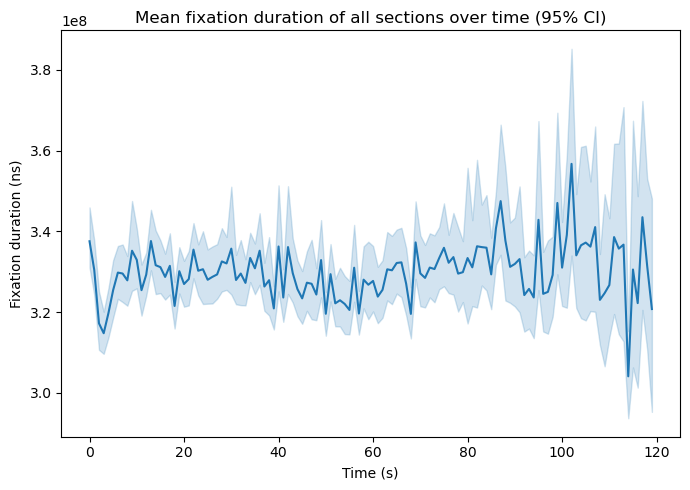

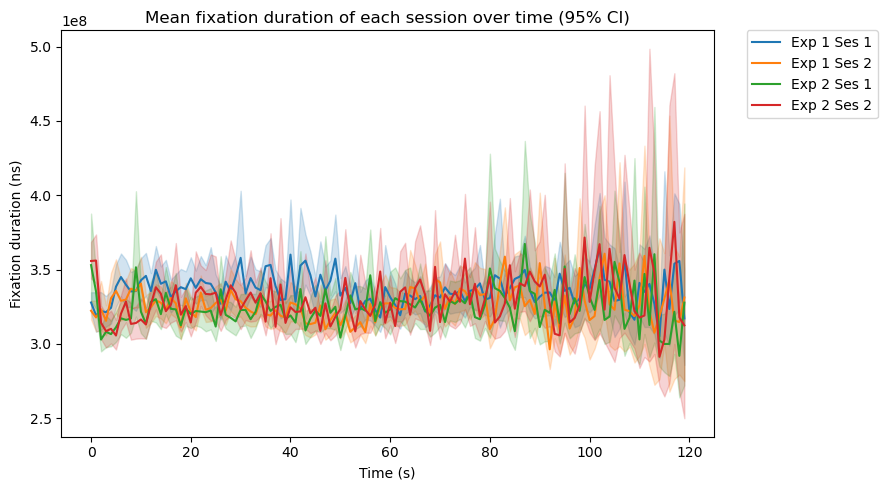

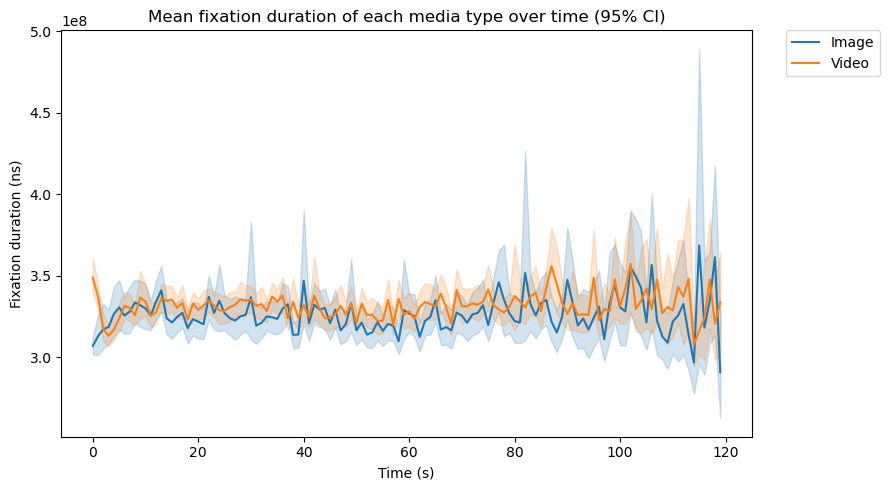

In [79]:
plot_fixation_duration_over_time(fixation_data)

## Global Saliency Map

In [6]:
def plot_global_saliency(
    data: pd.DataFrame,
    n_samples = 10000,
) -> None:
    """
    Plot the global saliency of the data.

    Args:
        data (pd.DataFrame): The data to plot.
        n_samples (int, optional): The number of samples to plot. Defaults to 10000.
    """
    # Subsample the data
    data = data.copy()
    data = data.sample(n=n_samples)

    # Plot the global saliency
    plt.figure(figsize=(5, 4))
    ax = plt.gca()
    ax.set_facecolor("black")
    sns.kdeplot(
        data=data,
        x="X_px",
        y="Y_px",
        fill=True,
        cmap="hot",
        levels=100,
        gridsize=100,
    )
    plt.xticks([])
    plt.xlabel("Gaze X")
    plt.yticks([])
    plt.ylabel("Gaze Y")
    plt.title("Global saliency heatmap")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

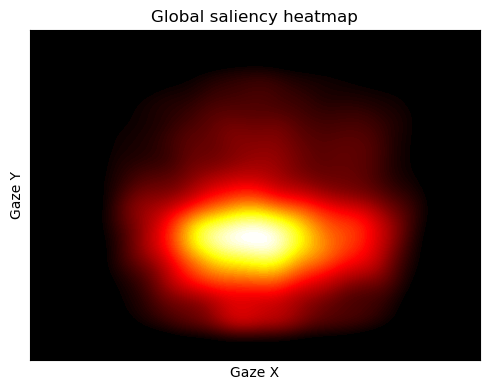

In [7]:
plot_global_saliency(data)

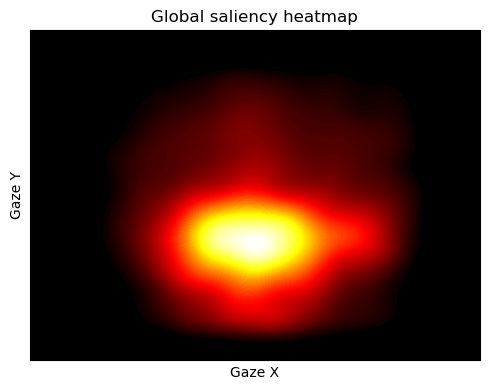

In [8]:
plot_global_saliency(interpolated_data)

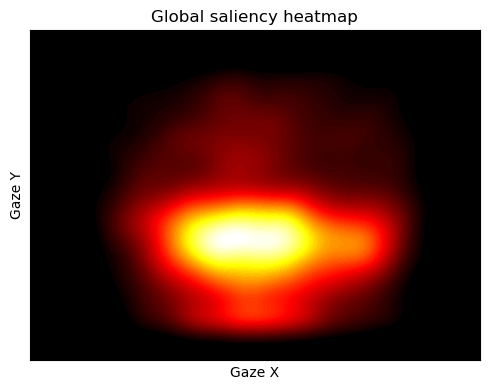

In [9]:
plot_global_saliency(fixation_data)